In [2]:
import os
import sys
from collections import defaultdict
from itertools import combinations
from functools import reduce, partial
import multiprocessing
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pymp

import ete3
from ete3 import PhyloTree
from Bio import SeqIO

import Levenshtein

In [12]:
path_to_genbank = "../data/external/human_mt_clean.gb"

In [13]:
dloops = []
npassed = nexdloop = 0
for rec in SeqIO.parse(path_to_genbank, format="gb"):
    feature_dloop = [x for x in rec.features if x.type == "D-loop"]
    if len(feature_dloop) == 1:
        cur_dloop = str(feature_dloop[0].extract(rec.seq)).upper()
        amb_share = 1 - sum([cur_dloop.count(x) for x in "ACGT"]) / len(cur_dloop)
        if amb_share > 0.05:
            npassed += 1
            continue
        dloops.append((rec.id, cur_dloop))
    else:
        # print(rec.id, feature_dloop)
        nexdloop += 1


In [14]:
len(dloops), npassed, nexdloop

(55180, 22, 3554)

In [43]:
dlens = [len(x[1]) for x in dloops if len(x[1]) < 1300 and len(x[1]) > 1100]
# pd.Series(dlens).value_counts().sort_index()
len(dloops) - len(dlens)

1821

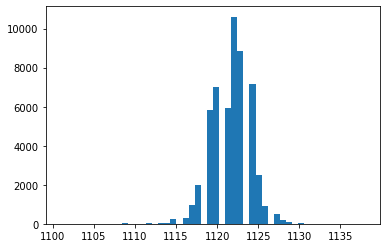

In [44]:
plt.hist(dlens, 50);

In [45]:
dloops_clean = [x for x in dloops if len(x[1]) < 1300 and len(x[1]) > 1100]

In [46]:
x = len(dloops_clean)
x * (x - 1) // 2

1423564761

In [56]:
# parallel version
n = len(dloops_clean)
# n = 2000
data = []


def get_distance(x):
    i, j = x
    d = Levenshtein.distance(dloops_clean[i][1], dloops_clean[j][1])
    return d


def get_iterator():
    for i in range(n):
        for j in range(i + 1, n):
            yield (i, j)


with Pool(24) as p:
    ds = p.map(get_distance, get_iterator())

: 

: 

In [37]:
# # parallel version
# n = len(dloops)
# n = 1000
# data = pymp.shared.list()
# with pymp.Parallel(24) as p:
#     for i in p.range(n):
#         for j in range(i + 1, n):
#             d = Levenshtein.distance(dloops[i][1], dloops[j][1])
#             data.append(d)
#             # data.append({
#             #     "id1": dloops[i][0],
#             #     "id2": dloops[j][0],
#             #     "dist": d,
#             # })

In [27]:
dists = np.array(ds)
np.save("../data/dloop_pairwise_dists.npy", dists)

In [ ]:
# # single thread version
# data = []
# for (id1, seq1), (id2, seq2) in tqdm.tqdm(combinations(dloops, 2), total=len(dloops) * len(dloops) // 2):
#     d = Levenshtein.distance(seq1, seq2)
#     data.append({
#         "id1": id1,
#         "id2": id2,
#         "dist": d,
#     })

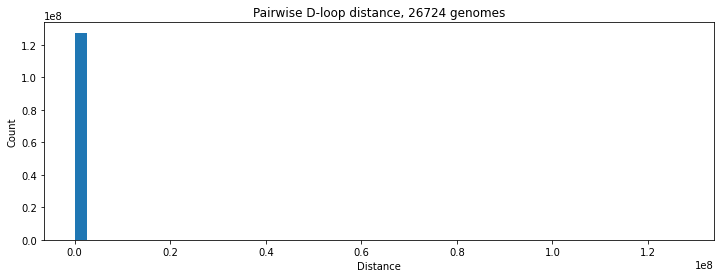

In [29]:
plt.figure(figsize=(12, 4))
plt.hist(dists, 50)
plt.title(f"Pairwise D-loop distance, {len(dloops)} genomes")
plt.xlabel("Distance")
plt.ylabel("Count")
# plt.xscale("log")
plt.savefig("../data/dists.png")
plt.show()

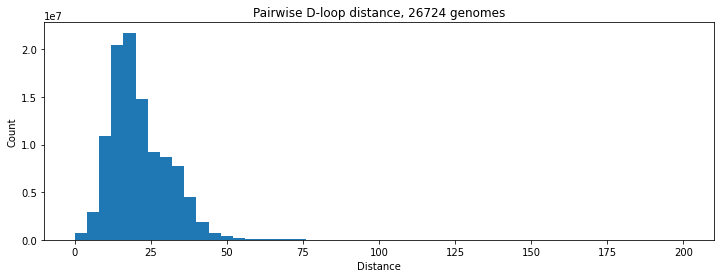

In [30]:
plt.figure(figsize=(12, 4))
plt.hist(dists, 50, (0, 200))
plt.title(f"Pairwise D-loop distance, {len(dloops)} genomes")
plt.xlabel("Distance")
plt.ylabel("Count")
# plt.xscale("log")
plt.savefig("../data/dists200.png")
plt.show()

In [31]:
(dists == 0).sum() / dists.shape[0]

0.0006275054438930718